In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

plt.rcParams['ytick.left']=True
plt.rcParams['xtick.bottom']=True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False


#im = imageio.imread('img/cover.png')[:,:,0]
im = imageio.imread('img/IMG_1179.JPG')[:,:,0]
im.shape

#im = (im-np.mean(im))/np.std(im)

(1280, 1277)

In [2]:
U,S,Vh = np.linalg.svd(im)

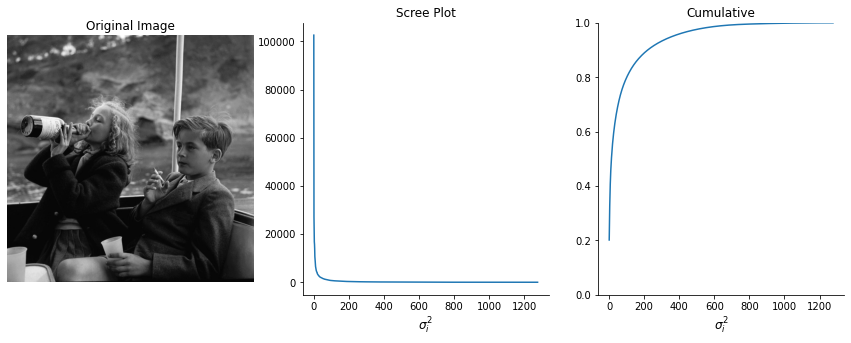

In [3]:
x = list(range(1,len(S)+1))

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(im,'gray')
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].axes.spines['left'].set_visible(False)
ax[0].axes.spines['bottom'].set_visible(False)
ax[0].set_title('Original Image')

ax[1].plot(x,S)
ax[1].set_title('Scree Plot',fontsize=12)
ax[1].set_xlabel('$\sigma_i^2$',fontsize=12)
ax[2].plot(x,np.cumsum(S)/np.sum(S))
ax[2].set_ylim([0,1])
ax[2].set_title('Cumulative',fontsize=12)
ax[2].set_xlabel('$\sigma_i^2$',fontsize=12)


plt.savefig('img/svd_scree.png',bbox_inches='tight')

In [4]:
im.shape

(1280, 1277)

# Optimal Truncation after Gavis et al

https://arxiv.org/abs/1305.5870

In [5]:
def omega(beta):
    return 0.56*beta**3 - 0.95*beta**2 + 0.82*beta + 1.43

def aspect(im):
    return im.shape[0]/im.shape[1]
    
def optimal_threshold(beta,S):
    return omega(beta)*np.median(S)

def get_filtered(im):
    
    # if m > n, then perform on transpose
    beta = aspect(im)
    if beta > 1:
        imc,Sc = get_filtered(im.T)
        return imc.T,Sc
    
    U,S,Vh = np.linalg.svd(im,full_matrices=False)
    
    tau = optimal_threshold(beta,S)
    
    mask = S > tau
    
    imc = U[:,mask]@np.diag(S[mask])@Vh[mask]
    return imc, S[mask]
    

def get_noisy(im,sigma):
    imn = im + np.random.randn(*im.shape)*sigma
    _,Sn,_ = np.linalg.svd(imn)
    return imn, Sn
      
    
def frobenius(A,B):
    return np.mean([(a-b)**2 for a,b in zip(A.flatten(),B.flatten())])

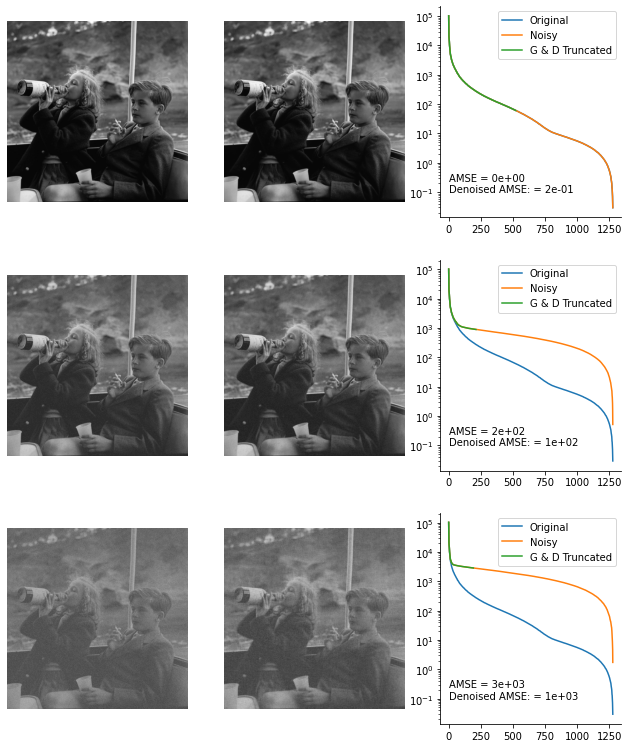

In [6]:
fig, axes = plt.subplots(3,3,figsize=(1.1*10,1.1*12))

_,S0,_ = np.linalg.svd(im)

noise_levels = [0,0.3*np.std(im),1*np.std(im)]
for i,ax in enumerate(axes):
    
    imn,Sn = get_noisy(im,noise_levels[i])
    
    imc,Sc = get_filtered(imn)
    

    ax[0].imshow(imn,'gray')
    ax[0].axes.get_xaxis().set_visible(False)
    ax[0].axes.get_yaxis().set_visible(False)
    ax[0].axes.spines['left'].set_visible(False)
    ax[0].axes.spines['bottom'].set_visible(False)
    
    ax[1].imshow(imc,'gray')
    ax[1].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)
    ax[1].axes.spines['left'].set_visible(False)
    ax[1].axes.spines['bottom'].set_visible(False)
    
    ax[2].semilogy(S0)
    ax[2].semilogy(Sn)
    ax[2].semilogy(Sc)
    
    ax[2].legend(['Original','Noisy','G & D Truncated'])
    
    ax[2].text(x=0,y=10**(-1),s='AMSE = %1.0e\nDenoised AMSE: = %1.0e' % (frobenius(imn,im),frobenius(imc,im)))

plt.savefig('img/truncated_svd.png',bbox_inches='tight')

In [8]:
amse = []
denoised_amse = []
retained = []

def normalize(X):
    return (X-np.mean(X))/np.std(X)


noise_levels = np.linspace(0.001,5,50)

for noise in noise_levels:
    
    noise = np.mean(im)*noise
    
    imn,Sn = get_noisy(im,noise)
    imc,Sc = get_filtered(im)
    
    retained += [len(Sc)/len(Sn)]
    amse += [frobenius(imn,im)]
    denoised_amse += [frobenius(imc,im)]

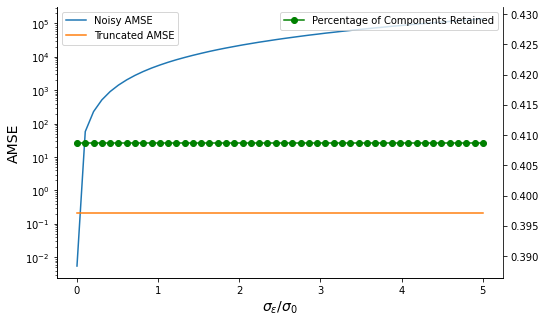

In [9]:
fig,ax = plt.subplots(figsize=(8,5))
ax.semilogy(noise_levels,amse)
ax.semilogy(noise_levels,denoised_amse)


ax.set_ylabel("AMSE",fontsize=14)
ax.set_xlabel("$\sigma_{\epsilon}/\sigma_{0}$",fontsize=14)

ax2=ax.twinx()
ax2.plot(noise_levels,retained,'o-',color='green')
ax2.axes.spines['right'].set_visible(True)

ax.legend(['Noisy AMSE','Truncated AMSE'])
ax2.legend(['Percentage of Components Retained'])

plt.savefig('img/truncated_svd2.png',bbox_inches='tight')